<a href="https://colab.research.google.com/github/jellycodes/correct-or-incorrect-push-up/blob/main/push_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

구글 드라이브 마운트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# 기존 경로 변경
os.chdir('/content/drive/MyDrive/dataset')

In [ ]:
pwd

'/content/drive/MyDrive/dataset'

In [ ]:
# yolov8 설치
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 824.8/824.8 kB 9.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

### 데이터세트 폴더 구성

- datasets
  - images
    - 훈련 이미지 폴더
      - 이미지1
      - 이미지2
      - 이미지3
      -...
    - 테스트 이미지 폴더
      - 이미지1
      - ...

zip 파일 풀기

In [ ]:
import zipfile
if not os.path.exists('/content/drive/MyDrive/dataset/datasets/pushup'):
  path = './pushup.zip'
  f_zip = zipfile.ZipFile(path)
  f_zip.extractall('/content/drive/MyDrive/dataset/datasets/pushup')
  f_zip.close()

In [ ]:
os.chdir('/content/drive/MyDrive/dataset/datasets')

데이터세트 구성

In [ ]:
import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras import layers
import numpy as np

# 데이터세트 구성

img_height = 224
img_width = 224
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
  'pushup/images/train',
  batch_size=batch_size,
  seed=42,
  shuffle=True,
  image_size=(img_height, img_width)
  )

val_ds = tf.keras.utils.image_dataset_from_directory(
  'pushup/images/test',
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 279 files belonging to 2 classes.
Found 20 files belonging to 2 classes.
['abnormal', 'normal']


In [ ]:
# 데이터 증강 전처리 (학습데이터에만 적용)

train_aug = tf.keras.Sequential([
        layers.RandomBrightness(0.2),
        layers.RandomFlip(),
        layers.RandomRotation(0.5),
        layers.RandomZoom(0.2,0.2)])

def data_augmentation(img, label):
  aug = train_aug(img)
  return aug, label

train_ds = train_ds.map(data_augmentation)
train_ds = train_ds.prefetch(buffer_size=1000)

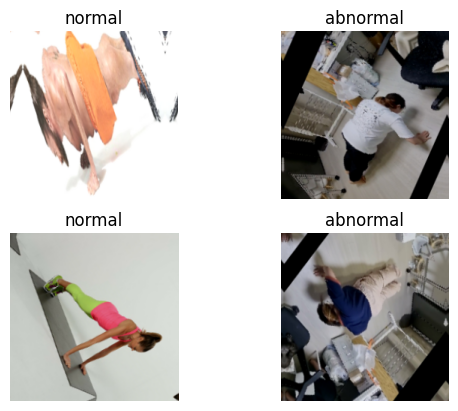

In [ ]:
import matplotlib.pyplot as plt

for feature, label in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(feature[i].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")

In [ ]:
# EfficientNetV2B0 모델 활용
base_model = tf.keras.applications.EfficientNetV2B0(input_shape=(img_height,img_width,3),
                                                    include_top=False,
                                                    weights='imagenet')

# base_model.trainable = False

rescale = tf.keras.layers.Rescaling(scale=1./127.5, offset=-1)
global_pooling = layers.GlobalMaxPooling2D() #(3)
bn = layers.BatchNormalization()
dr1 = layers.Dropout(0.4)
dense1 = layers.Dense(128)
dr2 = layers.Dropout(0.4)
dense2 = layers.Dense(64)
dr3 = layers.Dropout(0.3)
dense3 = layers.Dense(4)
softmax = layers.Softmax()

inp = tf.keras.Input((img_height,img_width,3))
x = rescale(inp)
x = base_model(x)
x = global_pooling(x)
x = bn(x)
x = dr1(x)
x = dense1(x)
x = dr2(x)
x = dense2(x)
x = dr3(x)
x = dense3(x)
out = softmax(x)
model = tf.keras.Model(inp, out, name = 'EfficientNet')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()
history = model.fit(train_ds, epochs=10, validation_data = val_ds)

24274472/24274472 [==============================] - 0s 0us/step
Model: "EfficientNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 7, 7, 1280)        5919312   
 nal)                                                            
                                                                 
 global_max_pooling2d (Glob  (None, 1280)              0         
 alMaxPooling2D)                                                 
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                        

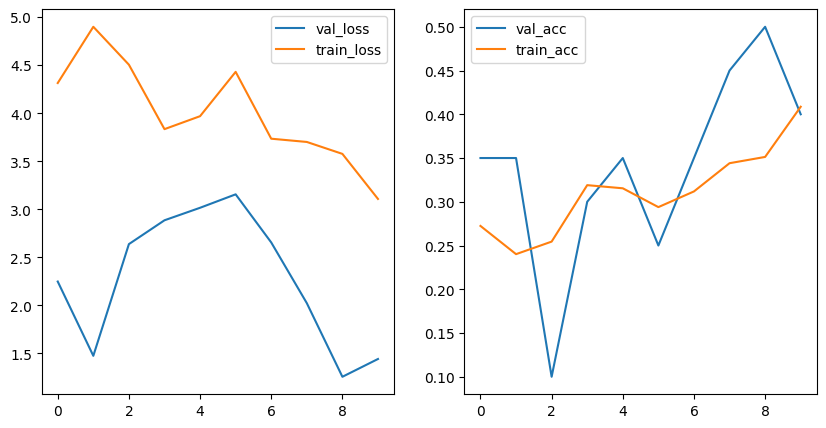

In [ ]:
import matplotlib.pyplot as plt

# 손실 및 정확도 변화 그래프

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

eps = range(len(val_loss))

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(eps, val_loss, label = 'val_loss')
ax1.plot(eps, loss, label = 'train_loss')
ax1.legend()

ax2 = fig.add_subplot(1,2,2)
ax2.plot(eps, val_acc, label = 'val_acc')
ax2.plot(eps, acc, label = 'train_acc')
ax2.legend()
plt.show()


[2.00004506111145,
 1.4269399642944336,
 0.933692216873169,
 1.012311339378357,
 0.7449985146522522,
 0.812138557434082,
 0.8660116195678711,
 0.7089017629623413,
 0.6509186029434204,
 0.6542165279388428,
 0.5158798098564148,
 0.6887404322624207,
 0.5459047555923462,
 0.5852319598197937,
 0.4303809106349945,
 0.5392237901687622,
 0.6726742386817932,
 0.46342048048973083,
 0.39589768648147583,
 0.4457477033138275]

#보틀넥 구조

In [ ]:
# 보틀넥 구조로 CNN 구성
def bt_block(inputs, filters):
    skipconv = layers.Conv2D(filters*4, 1, 2, use_bias=False)
    skipbn = layers.BatchNormalization()

    conv1 = layers.Conv2D(filters, 1, 1, use_bias=False)
    conv2 = layers.Conv2D(filters, 3, 2, padding='same', use_bias=False)
    conv3 = layers.Conv2D(filters*4, 1, 1,use_bias=False)

    bn1 = layers.BatchNormalization()
    bn2 = layers.BatchNormalization()
    bn3 = layers.BatchNormalization()

    active = layers.LeakyReLU()
    add = layers.Add()

    x = conv1(inputs)
    x = bn1(x)
    x = active(x)

    x = conv2(x)
    x = bn2(x)
    x = active(x)

    x = conv3(x)
    x = bn3(x)
    x = active(x)

    shortcut = skipconv(inputs)
    shortcut = skipbn(shortcut)

    x = x + shortcut
    return x

rescale = layers.Rescaling(1./127.5, offset=-1)
global_pooling = layers.GlobalAveragePooling2D()
bn = layers.BatchNormalization()
dr = layers.Dropout(0.4)
dense1 = layers.Dense(64)
dense2 = layers.Dense(4)
softmax = layers.Softmax()


inp = tf.keras.Input((img_height,img_width,3))
x = rescale(inp)
x = bt_block(x, 16)
x = bt_block(x, 32)
x = bt_block(x, 64)
x = bt_block(x, 64)
x = bt_block(x, 128)

x = global_pooling(x)
x = bn(x)
x = dr(x)
x = dense1(x)
x = dense2(x)
out = softmax(x)

model2 = tf.keras.Model(inp, out, name = 'bt_cnn')
print(model2.summary())

model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history = model2.fit(train_ds, epochs=10, validation_data = val_ds)

Model: "bt_cnn"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 224, 224, 16)         48        ['rescaling_2[0][0]']         
                                                                                                  
 batch_normalization_3 (Bat  (None, 224, 224, 16)         64        ['conv2d_1[0][0]']            
 chNormalization)                                                                            

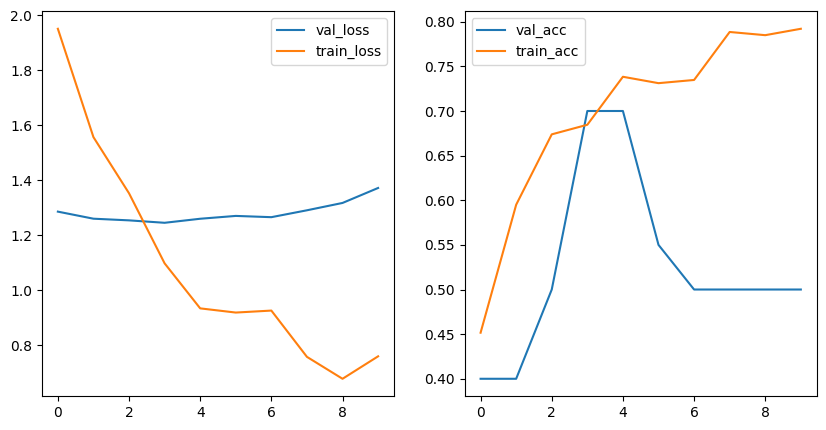

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

eps = range(len(val_loss))

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(eps, val_loss, label = 'val_loss')
ax1.plot(eps, loss, label = 'train_loss')
ax1.legend()

ax2 = fig.add_subplot(1,2,2)
ax2.plot(eps, val_acc, label = 'val_acc')
ax2.plot(eps, acc, label = 'train_acc')
ax2.legend()
plt.show()

{'loss': [2.00004506111145,
  1.4269399642944336,
  0.933692216873169,
  1.012311339378357,
  0.7449985146522522,
  0.812138557434082,
  0.8660116195678711,
  0.7089017629623413,
  0.6509186029434204,
  0.6542165279388428,
  0.5158798098564148,
  0.6887404322624207,
  0.5459047555923462,
  0.5852319598197937,
  0.4303809106349945,
  0.5392237901687622,
  0.6726742386817932,
  0.46342048048973083,
  0.39589768648147583,
  0.4457477033138275],
 'accuracy': [0.36200717091560364,
  0.5734767317771912,
  0.7311828136444092,
  0.6881720423698425,
  0.7670251131057739,
  0.8064516186714172,
  0.7419354915618896,
  0.8136200904846191,
  0.8207885026931763,
  0.8028674125671387,
  0.8315412402153015,
  0.8100358247756958,
  0.8172042965888977,
  0.8387096524238586,
  0.8781362175941467,
  0.8817204236984253,
  0.8387096524238586,
  0.8745519518852234,
  0.8853046298027039,
  0.8888888955116272],
 'val_loss': [1.3317360877990723,
  1.2802234888076782,
  1.2292492389678955,
  1.1981111764907837,
